# Predict stock future behavior

Following the tutorial on [Github](https://github.com/dataquestio/project-walkthroughs/tree/master/stock) and [YouTube](https://www.youtube.com/watch?v=SYrFhugaoZk&list=PL6UJrXaOPPcEesMFPaieQJwnBvKiRH2tT&index=40).

I want to make money by buying stocks. Since I want to make money, I only want to buy stock on days when the price will go up. So, I want to create a machine learning algorithm to predict if the stock price will increase tomorrow. If the algorithm says that the price will increase, I'll buy stock. If the algorithm says that the price will go down, I won't do anything.

For this purpose, I want to maximize the `true positives` - days when the algorithm predicts that the price will go up, and it actually goes go up. Therefore, I'll be using `precision` as error metric for the algorithm. It is defined as:

<center> `precision` = `true positives / (false positives + true positives)` </center>
    
This will ensure that I minimize how much money I lose with false positives (days when we buy the stock, but the price actually goes down).

This means that I will have to accept a lot of `false negatives` - days when I predict that the price will go down, but it actually goes up. This is okay, since I'd rather minimize the potential losses than maximize the potential gains.

## Method
Before we get to the machine learning, we need to do a lot of work to acquire and clean up the data. Here are the steps we'll follow:
- Download historical stock prices from Yahoo finance
- Explore the data
- Setup the dataset to predict future prices using historical prices
- Test a machine learning model
- Setup a backtesting engine
- Improve the accuracy of the model
 
At the end, we'll document some potential future directions we can go in to improve the technique.

## Data
I will use Microsoft stock data since there is a long history of that.

In [6]:
#! pip install yfinance

# Import libraries and download data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import json
import os

The following cell is used if you have already downloaded the data as `.json` file. I won't use it.

In [7]:
"""
DATA_PATH = "msft_data.json"

if os.path.exists(DATA_PATH):
    # Read from file if we've already downloaded the data.
    with open(DATA_PATH) as f:
        msft_hist = pd.read_json(DATA_PATH)
else:
    msft = yf.Ticker("MSFT")
    msft_hist = msft.history(period="max")

    # Save file to json in case we need it later.  This prevents us from having to re-download it every time.
    msft_hist.to_json(DATA_PATH)
"""

'\nDATA_PATH = "msft_data.json"\n\nif os.path.exists(DATA_PATH):\n    # Read from file if we\'ve already downloaded the data.\n    with open(DATA_PATH) as f:\n        msft_hist = pd.read_json(DATA_PATH)\nelse:\n    msft = yf.Ticker("MSFT")\n    msft_hist = msft.history(period="max")\n\n    # Save file to json in case we need it later.  This prevents us from having to re-download it every time.\n    msft_hist.to_json(DATA_PATH)\n'

In [9]:
msft = yf.Ticker("MSFT")
msft_hist = msft.history(period="max")

# Explore the data

In [14]:
type(msft_hist), msft_hist.shape

(pandas.core.frame.DataFrame, (9835, 7))

In [16]:
msft_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13 00:00:00-05:00,0.054376,0.062373,0.054376,0.059707,1031788800,0.0,0.0
1986-03-14 00:00:00-05:00,0.059707,0.062906,0.059707,0.061839,308160000,0.0,0.0
1986-03-17 00:00:00-05:00,0.061839,0.063439,0.061839,0.062906,133171200,0.0,0.0
1986-03-18 00:00:00-05:00,0.062906,0.063439,0.060773,0.061306,67766400,0.0,0.0
1986-03-19 00:00:00-05:00,0.061306,0.061839,0.059707,0.060240,47894400,0.0,0.0


<Axes: xlabel='Date'>

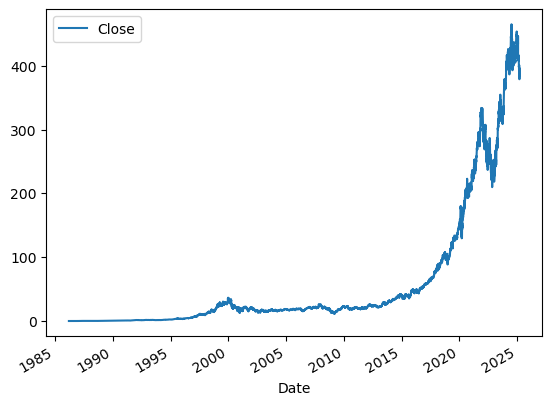

In [22]:
msft_hist.plot.line(y='Close', use_index=True)

## Prepare the data

I will add a column which tells whether the price of the stock has increased (1) or not (0) from the previous day, which will be our target.

In [26]:
data = msft_hist[['Close']].copy()

In [28]:
data.head()

,Close
Date,
1986-03-13 00:00:00-05:00,0.059707
1986-03-14 00:00:00-05:00,0.061839
1986-03-17 00:00:00-05:00,0.062906
1986-03-18 00:00:00-05:00,0.061306
1986-03-19 00:00:00-05:00,0.060240


In [32]:
data = data.rename(columns={'Close' : 'Actual Close'})
data.head()

,Actual Close
Date,
1986-03-13 00:00:00-05:00,0.059707
1986-03-14 00:00:00-05:00,0.061839
1986-03-17 00:00:00-05:00,0.062906
1986-03-18 00:00:00-05:00,0.061306
1986-03-19 00:00:00-05:00,0.060240


In [35]:
# rolling goes through the row 2 by 2
data['Target'] = msft_hist.rolling(2).apply(lambda x : x.iloc[1] > x.iloc[0] )["Close"]
data.head()

,Actual Close,Target
Date,,
1986-03-13 00:00:00-05:00,0.059707,NaN
1986-03-14 00:00:00-05:00,0.061839,1.0
1986-03-17 00:00:00-05:00,0.062906,1.0
1986-03-18 00:00:00-05:00,0.061306,0.0
1986-03-19 00:00:00-05:00,0.060240,0.0


I want to predict the price of the stock, but I can't give the model the actual price to train it. So I am going to shift the `Close` column in the original dataset by 1. `Actual_close` will be my target.

In [40]:
# shift the prices by 1 day, so we're predicting tomorrow's stock prices from today's prices.
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)

In [42]:
msft_hist.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

In [44]:
# our predictors / inputs / features
predictors = ['Open', 'High', 'Low', 'Close', 'Volume']
# copy these columns to data dataset, skip the first row which has a NaN because no history data for the first day
data = data.join(msft_prev[predictors]).iloc[1:]

In [46]:
data.head()

,Actual Close,Target,Open,High,Low,Close,Volume
Date,,,,,,,
1986-03-14 00:00:00-05:00,0.061839,1.0,0.054376,0.062373,0.054376,0.059707,1.031789e+09
1986-03-17 00:00:00-05:00,0.062906,1.0,0.059707,0.062906,0.059707,0.061839,3.081600e+08
1986-03-18 00:00:00-05:00,0.061306,0.0,0.061839,0.063439,0.061839,0.062906,1.331712e+08
1986-03-19 00:00:00-05:00,0.060240,0.0,0.062906,0.063439,0.060773,0.061306,6.776640e+07
1986-03-20 00:00:00-05:00,0.058641,0.0,0.061306,0.061839,0.059707,0.060240,4.789440e+07


# Create the Model

Next, we'll create a machine learning model to see how accurately we can predict the stock price.

Because we're dealing with time series data, we can't just use cross-validation to create predictions for the whole dataset. This will cause leakage where data from the future will be used to predict past prices. This doesn't match with the real world, and will make us think that our algorithm is much better than it actually is.

Instead, we'll split the data sequentially. We'll start off by predicting just the last 100 rows using the other rows.

We'll use a random forest classifier to generate our predictions. This is a good "default" model for a lot of applications, because it can pick up nonlinear relationships in the data, and is somewhat robust to overfitting with the right parameters.

We use `Classifier` because our target is `0`, `1`, so a classification task.

In [58]:
from sklearn.ensemble import RandomForestClassifier

In [65]:
# create model
model = RandomForestClassifier(n_estimators=100,     # how many individual decision trees, then avg the results 
                              min_samples_split=200, # RandomForest can easily overfit the data, 
                                                     # this prevents the tree from fitting itself to the data
                               random_state=1,       # if you rerun the model it will give the same result
                              )

Let's try with just a quick look, we will do it more appropriately later.

In [68]:
# split the data in train and test
train = data.iloc[:-100]
test = data.iloc[-100:]

In [74]:
print("Train dataset's shape is: ", train.shape)
print("Test dataset's shape is: ", test.shape)
print("Fraction: ", round(test.shape[0]/data.shape[0],3))

Train dataset's shape is:  (9734, 7)
Test dataset's shape is:  (100, 7)
Fraction:  0.01


In [76]:
# fit the model
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

I could use `n_estimators` larger, but this now fits the model quickly.

# Evaluate the model

In [83]:
from sklearn.metrics import precision_score

In [86]:
preds = model.predict(test[predictors])

In [88]:
preds

array([1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [90]:
preds = pd.Series(preds, index=test.index)

In [92]:
preds

Date
2024-10-29 00:00:00-04:00    1.0
2024-10-30 00:00:00-04:00    0.0
2024-10-31 00:00:00-04:00    0.0
2024-11-01 00:00:00-04:00    0.0
2024-11-04 00:00:00-05:00    1.0
                            ... 
2025-03-19 00:00:00-04:00    1.0
2025-03-20 00:00:00-04:00    1.0
2025-03-21 00:00:00-04:00    1.0
2025-03-24 00:00:00-04:00    1.0
2025-03-25 00:00:00-04:00    1.0
Length: 100, dtype: float64

In [96]:
precision_score = precision_score(test["Target"], preds)
precision_score                          

0.5769230769230769

Combine prediction and target columns in one dataframe

In [99]:
combined = pd.concat({'target': test['Target'], 'prediction': preds}, axis=1)

In [103]:
combined

,target,prediction
Date,,
2024-10-29 00:00:00-04:00,1.0,1.0
2024-10-30 00:00:00-04:00,1.0,0.0
2024-10-31 00:00:00-04:00,0.0,0.0
2024-11-01 00:00:00-04:00,1.0,0.0
2024-11-04 00:00:00-05:00,0.0,1.0
...,...,...
2025-03-19 00:00:00-04:00,1.0,1.0
2025-03-20 00:00:00-04:00,0.0,1.0
2025-03-21 00:00:00-04:00,1.0,1.0


<Axes: xlabel='Date'>

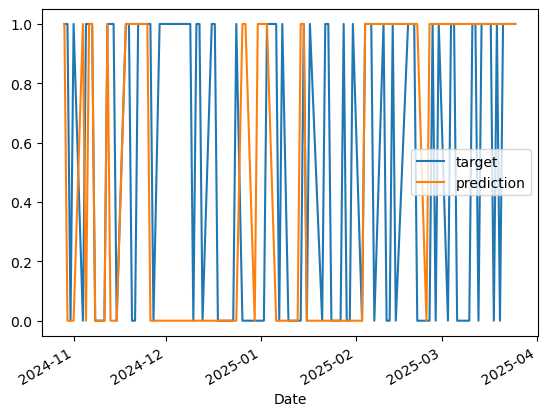

In [105]:
combined.plot()

# Backtesting

Our model isn't great, but luckily we can still improve it. Before we do that, let's figure out how to make predictions across the entire dataset, not just the last 100 rows. This will give us a more robust error estimate. The last 100 days may have has atypical market conditions or other issues that make error metrics on those days unrealistic for future predictions (which are what we really care about).

To do this, we'll need to backtest. Backtesting ensures that we only use data from before the day that we're predicting. If we use data from after the day we're predicting, the algorithm is unrealistic (in the real world, you won't be able to use future data to predict that past!).

Our backtesting method will loop over the dataset, and train a model every 750 rows. We'll make it a function so we can avoid rewriting the code if we want to backtest again.

In the backtesting function, we will:
* Split the training and test data
* Train a model
* Make predictions on the test data using predict_proba - this is because we want to really optimize for true positives. By default, the threshold for splitting 0/1 is .5, but we can set it to different values to tweak the precision. If we set it too high, we'll make fewer trades, but will have a lower potential for losses.